In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
ap = pd.read_csv('data/time_series_basic/AirPassengers.csv')
ap = ap['#Passengers']

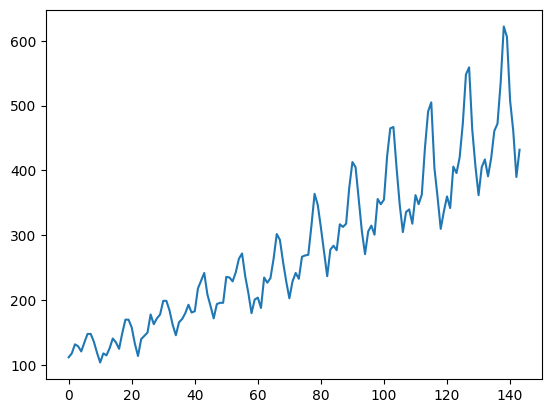

In [7]:
plt.figure()
plt.plot(ap)
plt.show()

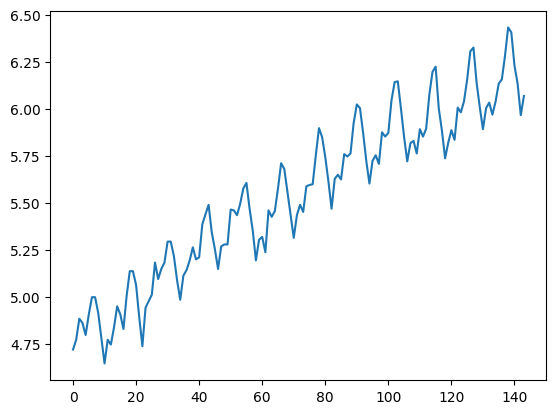

In [15]:
log_transformed = np.log(ap)

plt.figure()
plt.plot(log_transformed)
plt.show()

In [19]:
diffed = log_transformed.diff()[1:]

In [22]:
seasonally_diffed = diffed.diff(12)
seasonally_diffed = seasonally_diffed.dropna()
seasonally_diffed

13     0.039164
14     0.000361
15    -0.020496
16    -0.012939
17     0.066148
         ...   
139   -0.045934
140    0.012024
141    0.031830
142   -0.050082
143   -0.009964
Name: #Passengers, Length: 131, dtype: float64

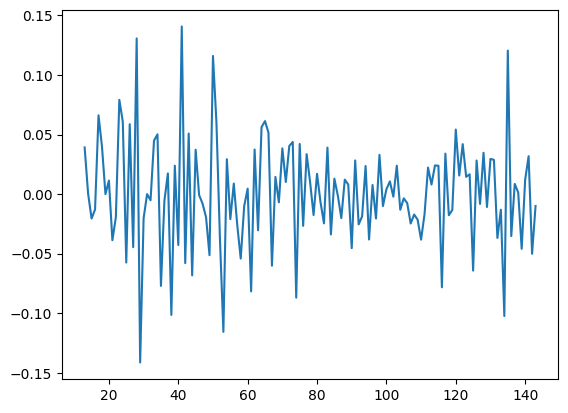

In [23]:
plt.figure()
plt.plot(seasonally_diffed)
plt.show()

In [24]:
from statsmodels.tsa.stattools import adfuller

def adf_test(x):
    stat, p_value, lags, nobs, crit, icb = adfuller(x)
    print('ADF Statistics')
    print(stat)
    print('P-value')
    print(p_value)

In [26]:
adf_test( seasonally_diffed )

ADF Statistics
-4.44332494183112
P-value
0.00024859123113840886


In [27]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [28]:
timeseries

id  time  F_x  F_y  F_z  T_x  T_y  T_z
0      1     0   -1   -1   63   -3   -1    0
1      1     1    0    0   62   -3   -1    0
2      1     2   -1   -1   61   -3    0    0
3      1     3   -1   -1   63   -2   -1    0
4      1     4   -1   -1   63   -3   -1    0
...   ..   ...  ...  ...  ...  ...  ...  ...
1315  88    10  -10    2   39  -21  -24    5
1316  88    11  -11    2   38  -24  -22    6
1317  88    12  -12    3   23  -24  -24    5
1318  88    13  -13    4   26  -29  -27    5
1319  88    14  -13    2   15  -25  -25    6

[1320 rows x 8 columns]

In [29]:
y

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

In [30]:
def custom_classification_split(x, y, test_size=0.3):
    num_true = int(y.sum() * test_size)
    num_false = int((len(y) - y.sum()) * test_size )
    
    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()
    
    y_train = y.drop(id_list)
    y_test = y.iloc[id_list].sort_index()

    x_train = timeseries[~timeseries['id'].isin(id_list)]
    x_test = timeseries[timeseries['id'].isin(id_list)]
    
    return x_train, y_train, x_test, y_test

In [35]:
x_train, y_train, x_test, y_test = custom_classification_split(timeseries, y, test_size=0.25)

In [36]:
x_train.shape, y_train.shape

((1005, 8), (67,))

In [37]:
x_test.shape, y_test.shape

((315, 8), (21,))

In [39]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

settings = EfficientFCParameters()

In [40]:
comprehensive_features_train = extract_features(x_train, column_id='id',
                                                column_sort='time',
                                                default_fc_parameters=settings
                                                )

Feature Extraction: 100%|██████████| 37/37 [00:03<00:00, 11.41it/s]


In [41]:
comprehensive_features_test = extract_features(x_test, column_id='id',
                                                column_sort='time',
                                                default_fc_parameters=settings
                                                )

Feature Extraction: 100%|██████████| 32/32 [00:01<00:00, 31.27it/s]


In [42]:
impute(comprehensive_features_train)

/home/drkail/projects/aiffel/.venv/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


F_x__variance_larger_than_standard_deviation  F_x__has_duplicate_max  \
6                                            1.0                     1.0   
7                                            0.0                     1.0   
8                                            1.0                     0.0   
9                                            1.0                     0.0   
10                                           0.0                     0.0   
..                                           ...                     ...   
84                                           1.0                     1.0   
85                                           1.0                     0.0   
86                                           1.0                     0.0   
87                                           1.0                     1.0   
88                                           1.0                     0.0   

    F_x__has_duplicate_min  F_x__has_duplicate  F_x__sum_values  \
6                      1.0                 1.0            -15.0   
7                      0.0                 1.0            -13.0   
8                      1.0                 1.0            -10.0   
9                      0.0                 1.0            -10.0   
10                     1.0                 1.0            -14.0   
..                     ...                 ...              ...   
84                     0.0                 1.0          -1073.0   
85                     1.0                 1.0            143.0   
86                     0.0                 0.0            961.0   
87                     0.0                 1.0           4509.0   
88                     1.0                 1.0           -143.0   

    F_x__abs_energy  F_x__mean_abs_change  F_x__mean_change  \
6              39.0              1.714286          0.142857   
7              21.0              0.928571          0.214286   
8              26.0              1.142857         -0.142857   
9              24.0              1.428571          0.000000   
10             14.0              0.142857          0.000000   
..              ...                   ...               ...   
84          96833.0              7.142857         -5.428571   
85           1683.0              1.357143          1.071429   
86          83497.0              9.071429          9.071429   
87        1405437.0             12.928571         12.214286   
88           1427.0              0.785714         -0.500000   

    F_x__mean_second_derivative_central  F_x__median  ...  \
6                              0.153846         -1.0  ...   
7                             -0.076923         -1.0  ...   
8                              0.192308         -1.0  ...   
9                             -0.076923         -1.0  ...   
10                             0.000000         -1.0  ...   
..                                  ...          ...  ...   
84                            -0.038462        -98.0  ...   
85                             0.076923          8.0  ...   
86                             0.807692         52.0  ...   
87                            -1.038462        338.0  ...   
88                             0.038462         -9.0  ...   

    T_z__fourier_entropy__bins_5  T_z__fourier_entropy__bins_10  \
6                       0.974315                       1.213008   
7                       1.255482                       1.494175   
8                       1.494175                       1.732868   
9                       1.255482                       1.494175   
10                      0.937285                       1.213008   
..                           ...                            ...   
84                      0.735622                       0.735622   
85                      0.735622                       0.735622   
86                      0.735622                       1.073543   
87                      0.735622                       0.735622   
88                      1.255482                       1.49

In [43]:
impute(comprehensive_features_test)

/home/drkail/projects/aiffel/.venv/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


F_x__variance_larger_than_standard_deviation  F_x__has_duplicate_max  \
1                                            0.0                     0.0   
2                                            0.0                     1.0   
3                                            0.0                     0.0   
4                                            0.0                     1.0   
5                                            0.0                     0.0   
19                                           1.0                     0.0   
20                                           1.0                     0.0   
21                                           1.0                     0.0   
22                                           1.0                     0.0   
23                                           1.0                     0.0   
24                                           1.0                     0.0   
25                                           1.0                     0.0   
26                                           1.0                     0.0   
27                                           1.0                     1.0   
28                                           1.0                     0.0   
29                                           1.0                     0.0   
30                                           1.0                     0.0   
31                                           1.0                     0.0   
32                                           1.0                     0.0   
33                                           1.0                     0.0   
34                                           1.0                     0.0   

    F_x__has_duplicate_min  F_x__has_duplicate  F_x__sum_values  \
1                      1.0                 1.0            -14.0   
2                      1.0                 1.0            -13.0   
3                      1.0                 1.0            -10.0   
4                      1.0                 1.0             -6.0   
5                      0.0                 1.0             -9.0   
19                     0.0                 1.0             99.0   
20                     1.0                 1.0            155.0   
21                     0.0                 1.0           -171.0   
22                     0.0                 1.0            102.0   
23                     0.0                 1.0             67.0   
24                     0.0                 1.0           -338.0   
25                     0.0                 1.0           -123.0   
26                     0.0                 1.0            -63.0   
27                     0.0                 1.0             50.0   
28                     0.0                 1.0            -28.0   
29                     0.0                 1.0            -51.0   
30                     1.0                 1.0             36.0   
31                     0.0                 1.0             43.0   
32                     0.0                 1.0            -15.0   
33                     0.0                 1.0             22.0   
34                     0.0                 1.0            173.0   

    F_x__abs_energy  F_x__mean_abs_change  F_x__mean_change  \
1              14.0              0.142857          0.000000   
2              25.0              1.000000          0.000000   
3              12.0              0.714286          0.000000   
4              16.0              1.214286         -0.071429   
5              17.0              0.928571         -0.071429   
19           6109.0             13.928571         -1.928571   
20          34455.0             16.714286        -13.142857   
21          16495.0             20.928571          1.785714   
22          12700.0             10.785714         -8.071429   
23          10593.0             15.142857         -7.000000   
24          37100.0             13.214286          9.071429   
25           6853.0              7.785714          5.214286   
26          18717.0             14.21

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=10, max_depth=3)

rf_clf.fit(comprehensive_features_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [46]:
rf_clf.score(comprehensive_features_test, y_test)

0.9047619047619048

In [45]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(n_estimators=10, max_depth=3)

xgb_clf.fit(comprehensive_features_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=10,
              n_jobs=None, num_parallel_tree=None, ...)

In [47]:
xgb_clf.score(comprehensive_features_test, y_test)

1.0

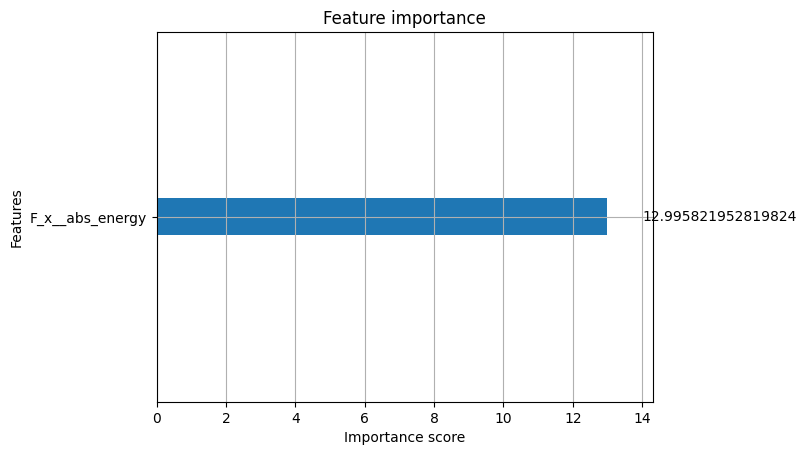

In [48]:
xgb.plot_importance(xgb_clf, importance_type='gain')
plt.show()

In [49]:
sum(xgb_clf.feature_importances_ != 0)

np.int64(1)

In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false']))

              precision    recall  f1-score   support

        true       1.00      1.00      1.00        16
       false       1.00      1.00      1.00         5

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

